# Remote Timing Attacks are Practical
_Experiment 6: Attacking SSL applications on the local network._

---

In [1]:
import scipy
import scipy.signal
import seaborn
import sympy
import numpy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [2]:
import tls
import attack

## Theory

In [3]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

## Bruteforce Top Few Bits of $q$
The aim of this notebook is to sample the server response times for a bunch of `g` values, and find out if the distribution is meaningfully different between them.

In [4]:
NEIGHBOURHOOD_SIZE = 400
SAMPLE_SIZE = 20
BRUTEFORCED_BITS = 4

filename = "./measurements/bruteforce-top-bits.txt"
if not os.path.exists(filename):
    gs = attack.bruteforce_most_significant_bits(num_bits=BRUTEFORCED_BITS)
    
    print("Taking {} samples...".format(len(gs)*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE))
    
    raw_samples = attack.sample(
        gs,
        sample_size=SAMPLE_SIZE,
        neighbourhood_size=NEIGHBOURHOOD_SIZE,
        u_g=True,
        N=N,
    )
    samples = pandas.DataFrame.from_records(
        raw_samples,
        columns=["point", "time"],
    )
    samples.to_csv(filename, sep=" ")

else:
    samples = pandas.read_csv(
        filename,
        sep=" ",
        usecols=["point", "time"],
    )

samples['point'] = samples['point'].apply(sympy.Integer)
samples

,point,time
0,6703903964971298549787012499102923063739682910...,3759062
1,6703903964971298549787012499102923063739682910...,3693961
2,6703903964971298549787012499102923063739682910...,3786702
3,6703903964971298549787012499102923063739682910...,3790809
4,6703903964971298549787012499102923063739682910...,3718205
...,...,...
63995,1256981993432118478085064843581798074451190545...,3592003
63996,1256981993432118478085064843581798074451190545...,3617352
63997,1256981993432118478085064843581798074451190545...,3678545
63998,1256981993432118478085064843581798074451190545...,3683341


In the paper, they take median time for each point. By taking the minimum, I hope to extract the fastest time possible, which should be the time with minimal context switches and other delays. This works provided the only sources of unwanted noise _add time_ (rather than remove it).

In [5]:
samples = samples.groupby(by="point").median().reset_index()
samples

,point,time
0,6703903964971298549787012499102923063739682910...,3674733.0
1,6703903964971298549787012499102923063739682910...,3596503.0
2,6703903964971298549787012499102923063739682910...,3618455.5
3,6703903964971298549787012499102923063739682910...,3601175.0
4,6703903964971298549787012499102923063739682910...,3602692.5
...,...,...
3195,1256981993432118478085064843581798074451190545...,3608102.5
3196,1256981993432118478085064843581798074451190545...,3606316.0
3197,1256981993432118478085064843581798074451190545...,3670993.5
3198,1256981993432118478085064843581798074451190545...,3611076.5


We can group samples into their respective "neighbourhoods" considering their most significant bits only.

In [6]:
def point_to_neighbourhood(point):
    point_int = sympy.Integer(point)
    point_bits = attack.sympy_integer_to_bits(point_int)
    neighbourhood_point_bits = point_bits[0:BRUTEFORCED_BITS] + [0] * (512-BRUTEFORCED_BITS)
    neighbourhood_point_int = attack.bits_to_sympy_integer(neighbourhood_point_bits)
    return neighbourhood_point_int

samples['neighbourhood'] = samples['point'].apply(point_to_neighbourhood)

Sum together the measurements in each neighbourhood:

In [7]:
samples = samples.groupby(by="neighbourhood").sum().reset_index()
samples

,neighbourhood,time
0,6703903964971298549787012499102923063739682910...,1.444297e+09
1,7541891960592710868510389061490788446707143274...,1.444326e+09
2,8379879956214123187233765623878653829674603637...,1.443389e+09
3,9217867951835535505957142186266519212642064001...,1.442807e+09
4,1005585594745694782468051874865438459560952436...,1.443718e+09
5,1089384394307836014340389531104224997857698472...,1.443896e+09
6,1173183193869977246212727187343011536154444509...,1.442998e+09
7,1256981993432118478085064843581798074451190545...,1.444686e+09


Since we know the factors of `N` (`q` and `p` with `q<p`) we can consider each point relative in size to these factors. When plotting, we are looking for peaks and troughs near whole multples of `p` and `q`.

In [8]:
sqrt_N = sympy.sqrt(N)
samples['point_relative_to_sqrt_n'] = samples['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 10))
samples

,neighbourhood,time,point_relative_to_sqrt_n
0,6703903964971298549787012499102923063739682910...,1.444297e+09,0.581823
1,7541891960592710868510389061490788446707143274...,1.444326e+09,0.654551
2,8379879956214123187233765623878653829674603637...,1.443389e+09,0.727278
3,9217867951835535505957142186266519212642064001...,1.442807e+09,0.800006
4,1005585594745694782468051874865438459560952436...,1.443718e+09,0.872734
5,1089384394307836014340389531104224997857698472...,1.443896e+09,0.945462
6,1173183193869977246212727187343011536154444509...,1.442998e+09,1.018190
7,1256981993432118478085064843581798074451190545...,1.444686e+09,1.090918


In [9]:
q_relative_to_sqrt_n = round(float(q/sqrt_N), 10)
p_relative_to_sqrt_n = round(float(p/sqrt_N), 10)

Now plot the media response time as we vary `g`:

In [10]:
smallest_time_observed = samples['time'].min()
largest_time_observed = samples['time'].max()

buffer = (largest_time_observed - smallest_time_observed)/10

smallest_time_observed, largest_time_observed, buffer

(1442806574.5, 1444685710.5, 187913.6)

In [11]:
if SAMPLE_SIZE == 20 and NEIGHBOURHOOD_SIZE == 800:
    error = 27442/(2*6529841)
elif SAMPLE_SIZE == 7 and NEIGHBOURHOOD_SIZE == 400:
    error = 42987/(2*6500856)
else:
    error = 0

In [12]:
ylim = (
    smallest_time_observed * (1 - error) - buffer,
    largest_time_observed * (1 + error) + buffer,
)

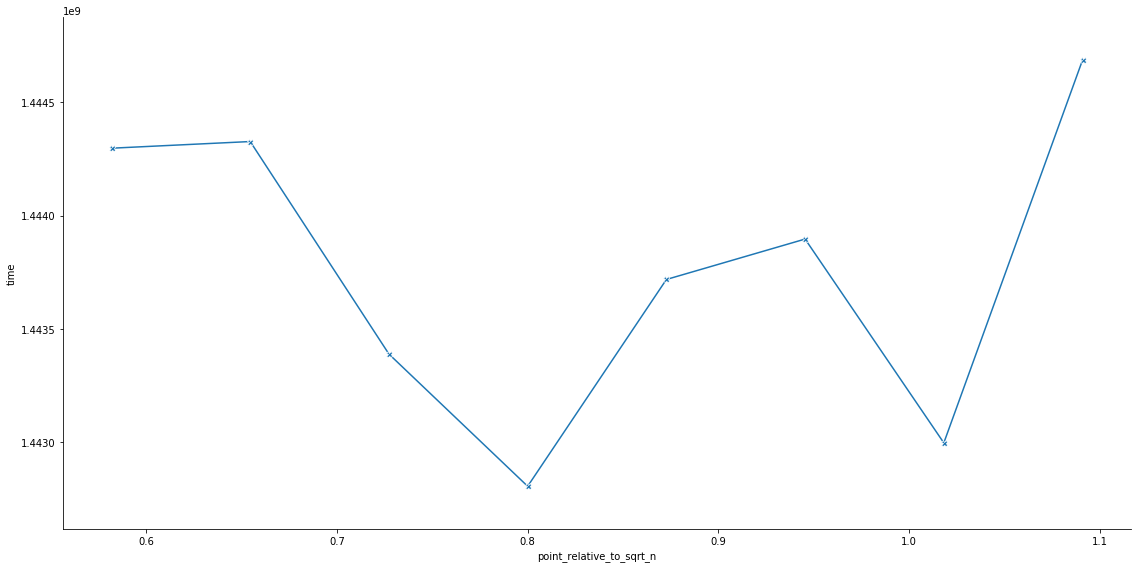

In [13]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

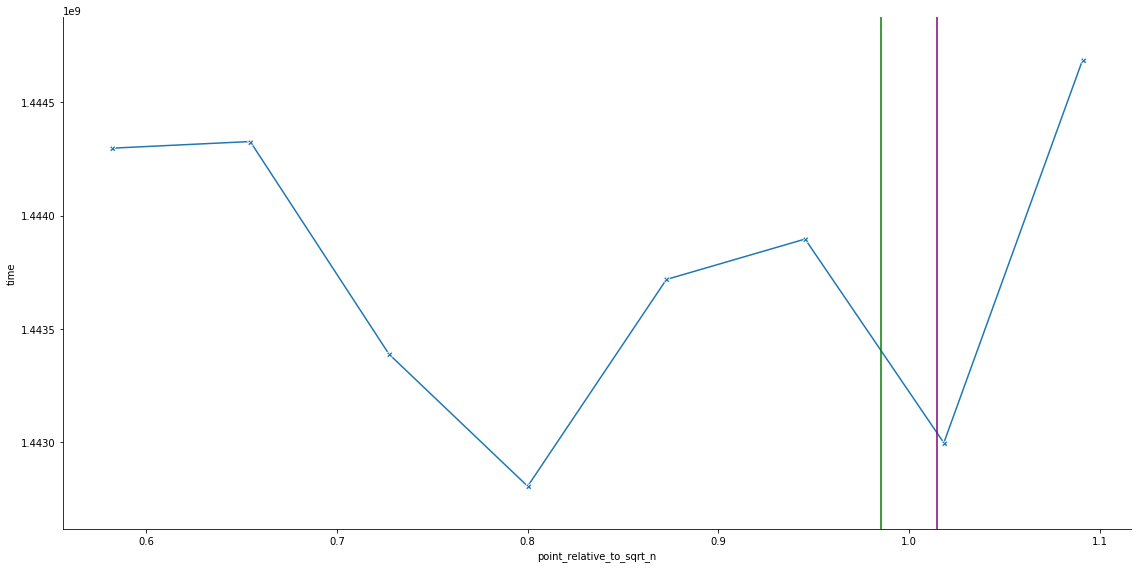

In [14]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

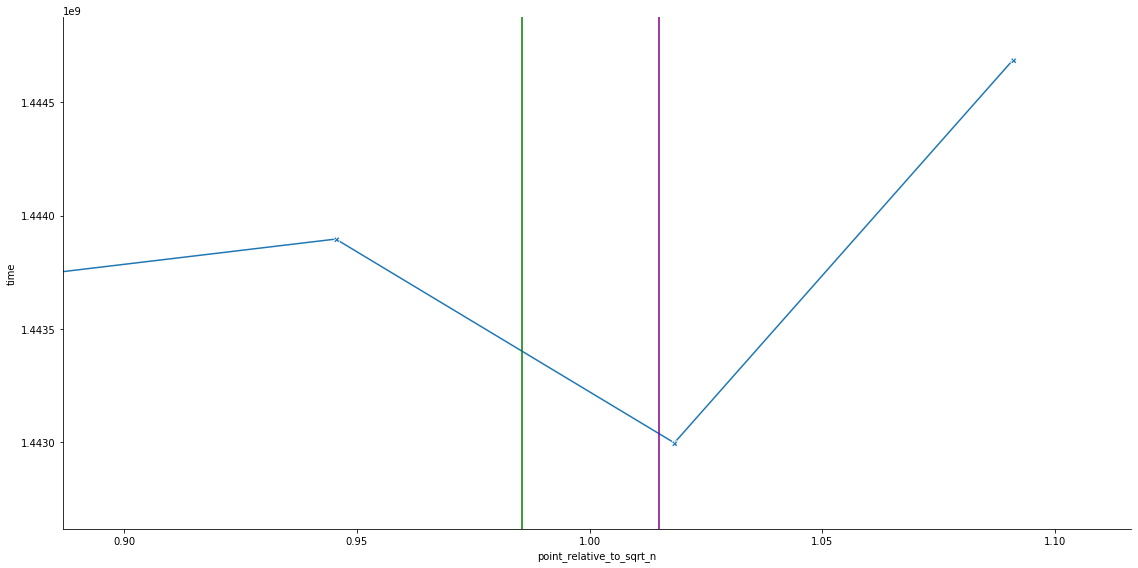

In [15]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g.set(xlim=(q_relative_to_sqrt_n*0.9, p_relative_to_sqrt_n*1.1))
g

In the section below, we bound the value of $q$ using the shape of this graph. But its worth noting that the peaks and troughs in the graphs above fit well inside the error bars (calculated in the `noise.ipynb` notebook). It is likely this graph should just be a straight line. 

### Bounding our search for `q`

`scipy` finds two peaks in the sample set.

In [16]:
peak_indices, _ = scipy.signal.find_peaks(samples['time'])
len(peak_indices)

2

Lets re-plot the above graph with the peaks highlighted:

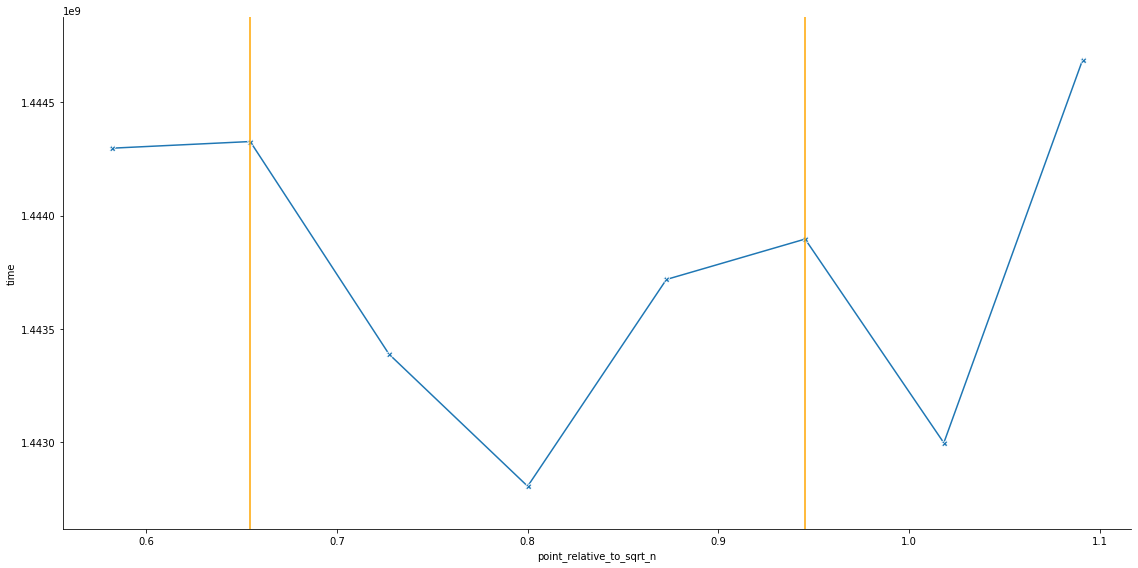

In [17]:
g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

for peak_index in peak_indices:
    peak = samples.iloc[peak_index]
    plt.plot([peak['point_relative_to_sqrt_n'], peak['point_relative_to_sqrt_n']], ylim, color='orange')

if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

I'm going to cheat a little and say that: we should always pick the peak closest to, but less than, $\sqrt{N}$. Why? We are looking for the peak that gives a lower bound on $q$. After the peak, the number of Montgomery reductions should dip significantly. It will slowly rise until it hits $p$, where it will immediately dip significantly again. We know that $q < \sqrt{n} < p$, so there shouldn't be any peaks in the interval $(q, p)$. Therefore, the peak closest to, but less than, $\sqrt{N}$ is the peak caused by the dip in Montgomery  reductions when $g = q$.

In [18]:
for peak_index in peak_indices:
    peak_row = samples.iloc[peak_index]
    peak_g = peak_row['neighbourhood']
    
    if peak_g > sqrt_N:
        peak_index -= 1    
        peak_row = samples.iloc[peak+index]
        peak_g = peak_row['neighbourhood']
        break
        
peak_row

neighbourhood               1089384394307836014340389531104224997857698472...
time                                                               1.4439e+09
point_relative_to_sqrt_n                                             0.945462
Name: 5, dtype: object

In [19]:
attack.sympy_integer_to_bits(peak_g)[0:BRUTEFORCED_BITS]

[1, 1, 0, 1]

This gives a lower bound on `q`. To get an upper bound on `q`, note the following:
  1. $q*p = N$
  2. $q < p$

From 1. and 2. it follows that $q < \sqrt{N}$.

(Suppose $q >= \sqrt{N}$, then by 2. $p > \sqrt{N}$ and so $ q*p > N$ which contradicts 1. Therefore $q < \sqrt{N}$.)

In [20]:
lower_bound = peak_g
upper_bound = sympy.Integer(sqrt_N.round())

lower_bound, upper_bound

(10893843943078360143403895311042249978576984729231319619400393673023933274434756918651522867260609034998150884776519916318675029784706588081477339817443328,
 11522245995293453226444537667133610590574234209345464522156603069988519317090416103523895551843843150180734266788088596830720220822331432054108383719953516)

Let's plot these two bounds on the graph:

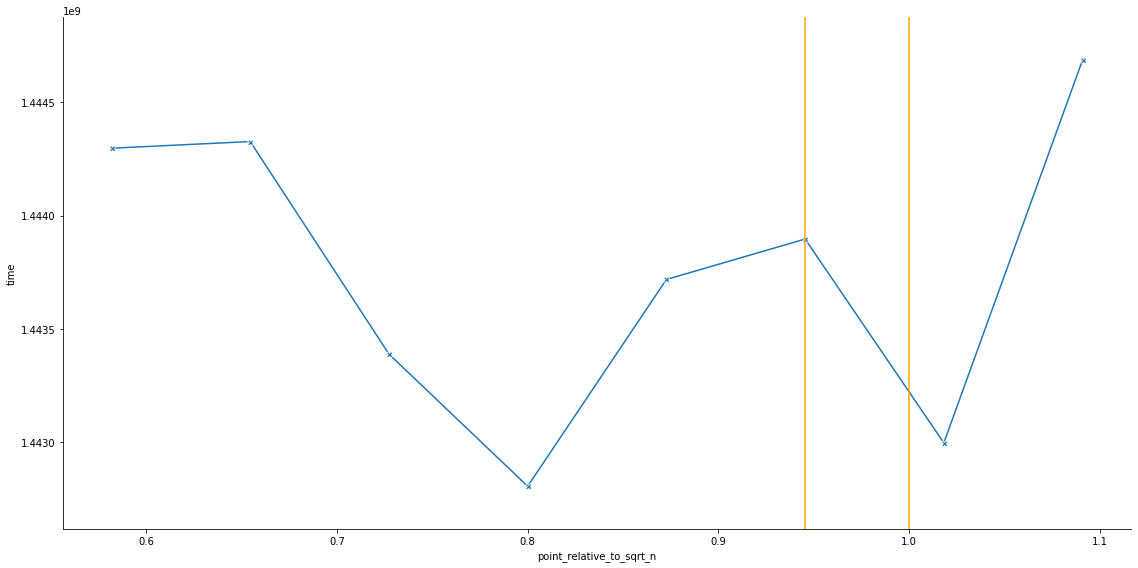

In [21]:
lower_bound_relative_to_sqrt_n = round(float(lower_bound/sqrt_N), 10)
upper_bound_relative_to_sqrt_n = round(float(upper_bound/sqrt_N), 10)

g = seaborn.relplot(data=samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

plt.plot([lower_bound_relative_to_sqrt_n, lower_bound_relative_to_sqrt_n], ylim, color='orange')
plt.plot([upper_bound_relative_to_sqrt_n, upper_bound_relative_to_sqrt_n], ylim, color='orange')

if error:
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1+error) for y in samples['time']], color='lightblue')
    plt.plot(samples['point_relative_to_sqrt_n'], [y*(1-error) for y in samples['time']], color='lightblue')
g.set(ylim=ylim)
g

Lets consider the bit representations of these two bounds so we can set in stone the first few bits.

In [22]:
print("Lower Bound:", attack.sympy_integer_to_bits(lower_bound)[0:BRUTEFORCED_BITS])
print("Upper Bound:", attack.sympy_integer_to_bits(upper_bound)[0:BRUTEFORCED_BITS])

Lower Bound: [1, 1, 0, 1]
Upper Bound: [1, 1, 0, 1]


In [23]:
lower_bound_bits = attack.sympy_integer_to_bits(lower_bound)
upper_bound_bits = attack.sympy_integer_to_bits(upper_bound)

known_q_bits = []
for i in range(BRUTEFORCED_BITS):
    if lower_bound_bits[i] == upper_bound_bits[i]:
        known_q_bits.append(lower_bound_bits[i])
    else:
        break
        
known_q_bits

[1, 1, 0, 1]

The above giving us the first bits of $q$.

Since it is prime, we also know that $q$ is odd, and so its least significant bit is 1. We'll ignore that for now.

# Recovering Bits of $q$

Run the iterative key recovery attack on bits 1, 2, and 3. We already know their true values, so there zero-one gaps can be used as reference points for the other bits.

In [24]:
q_bits = attack.sympy_integer_to_bits(q)

In [25]:
BITS_TO_RECOVER = 14
bit_samples_filename = "./measurements/bit-samples.txt"

In [26]:
if not os.path.exists(bit_samples_filename):
    bit_samples = pandas.DataFrame({
        'bit_position': [],
        'bit_value': [],
        'point': [],
        'time': [],
    })

    bits = []
    for i in range(0, BITS_TO_RECOVER):
        g_low_samples, g_high_samples = attack.sample_ith_bit(
            q_bits,
            i,
            sample_size=SAMPLE_SIZE,
            neighbourhood_size=NEIGHBOURHOOD_SIZE,
        )

        g_low_samples['bit_position'] = i
        g_low_samples['bit_value'] = 0

        g_high_samples['bit_position'] = i
        g_high_samples['bit_value'] = 1

        bit_samples = pandas.concat([bit_samples, g_low_samples, g_high_samples], axis=0, sort=True)

    bit_samples.to_csv(bit_samples_filename, sep=" ")

In [27]:
bit_samples = pandas.read_csv(bit_samples_filename, sep=" ").drop("Unnamed: 0", axis=1)
bit_samples

,bit_position,bit_value,point,time
0,0.0,0.0,0,675625.0
1,0.0,0.0,0,657238.0
2,0.0,0.0,0,658163.0
3,0.0,0.0,0,659660.0
4,0.0,0.0,0,664275.0
...,...,...,...,...
223995,13.0,1.0,1135457367113974211160825176087073455925147709...,3603538.0
223996,13.0,1.0,1135457367113974211160825176087073455925147709...,3595978.0
223997,13.0,1.0,1135457367113974211160825176087073455925147709...,3680834.0
223998,13.0,1.0,1135457367113974211160825176087073455925147709...,3596585.0


Next, collate the sample sets and neighbourhoods to provide a single measurement for each bit position and value combination.

In [28]:
bit_timings = bit_samples\
    .groupby(["bit_position", "bit_value", "point"]).median()\
    .groupby(["bit_position", "bit_value"]).sum()\
    .reset_index()

bit_timings

,bit_position,bit_value,time
0,0.0,0.0,1.441191e+09
1,0.0,1.0,1.444202e+09
2,1.0,0.0,1.444100e+09
3,1.0,1.0,1.443515e+09
4,2.0,0.0,1.444218e+09
5,2.0,1.0,1.444374e+09
6,3.0,0.0,1.443913e+09
7,3.0,1.0,1.443130e+09
8,4.0,0.0,1.443591e+09
9,4.0,1.0,1.443068e+09


To replicate the paper, we calculate the zero-one gap for each bit position:

In [29]:
def calc_zero_one_gap(row):
    T_g_low = row[row['bit_value']==0]['time'].iloc[0]
    T_g_high = row[row['bit_value']==1]['time'].iloc[0]
    return abs(T_g_low-T_g_high)

zero_one_gaps = bit_timings.groupby("bit_position").apply(calc_zero_one_gap)
zero_one_gaps

bit_position
0.0     3011335.5
1.0      584582.0
2.0      156045.0
3.0      783085.5
4.0      523536.0
5.0      585343.5
6.0      812370.0
7.0      344772.5
8.0     1695745.0
9.0      347639.0
10.0    1309327.5
11.0     536910.0
12.0     874217.5
13.0     549665.5
dtype: float64

Plot the gap for each bit position, with a color to denote its true value. Can we separate these into two distinct distributions?

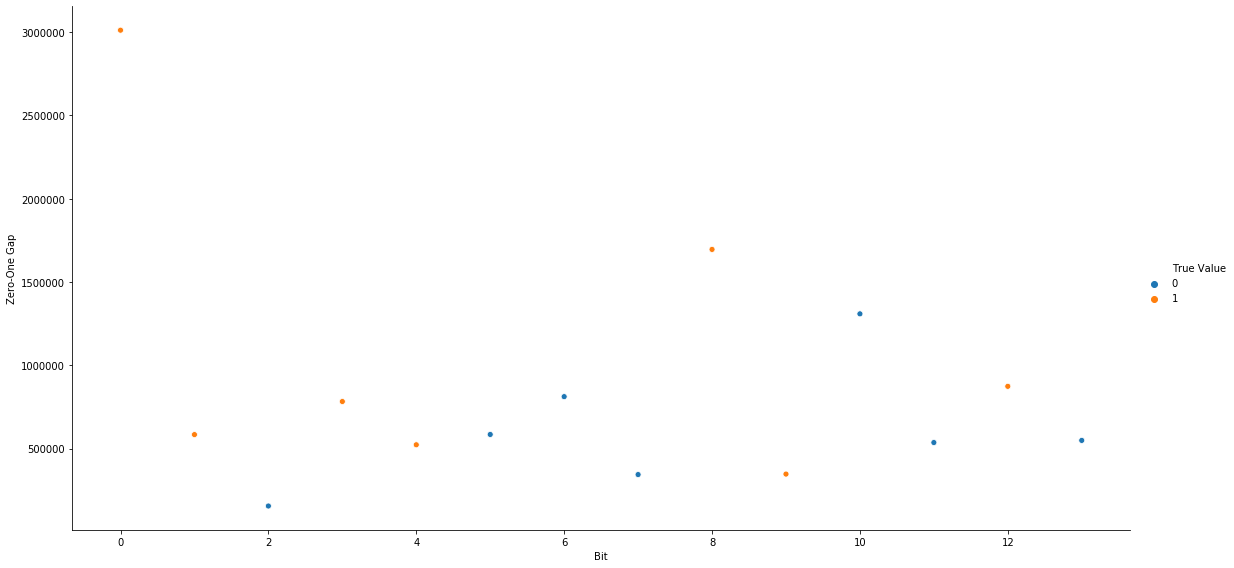

In [30]:
seaborn.relplot(
    data=pandas.DataFrame({
        'True Value': q_bits[0:BITS_TO_RECOVER],
        'Zero-One Gap': zero_one_gaps,
        'Bit': range(0, BITS_TO_RECOVER),
    }),
    x='Bit',
    y='Zero-One Gap',
    hue='True Value',
    kind='scatter',
    height=8,
    aspect=16/8,
)

These results aren't great, which is sad given that this is the first set of measurements since I fixed the Montogomery transform bug in `attack.py`. Plotting the zero-one gaps shows that there isn't a consistent way of separating them. Further, the first 4 bits show the opposite pattern to the one we'd expect.

To investigate, I plot the timings for each point in a graph similar to the one in ["Bruteforce Top Few Bits of $q$"](#Bruteforce-Top-Few-Bits-of-$q$). The resulting graph is a little erratic, but isn't too discouraging. I think taking more samples might be worth it.

In [31]:
def calc_point(row):
    bit_position, bit_value = int(row['bit_position']), int(row['bit_value'])
    point_bits = q_bits[0:bit_position] + [bit_value] + [0]*(len(q_bits) - 1 - bit_position)
    point = attack.bits_to_sympy_integer(point_bits)
    return point

bit_timings['neighbourhood'] = bit_timings.apply(calc_point, axis=1)

bit_timings

,bit_position,bit_value,time,neighbourhood
0,0.0,0.0,1.441191e+09,0
1,0.0,1.0,1.444202e+09,6703903964971298549787012499102923063739682910...
2,1.0,0.0,1.444100e+09,6703903964971298549787012499102923063739682910...
3,1.0,1.0,1.443515e+09,1005585594745694782468051874865438459560952436...
4,2.0,0.0,1.444218e+09,1005585594745694782468051874865438459560952436...
5,2.0,1.0,1.444374e+09,1173183193869977246212727187343011536154444509...
6,3.0,0.0,1.443913e+09,1005585594745694782468051874865438459560952436...
7,3.0,1.0,1.443130e+09,1089384394307836014340389531104224997857698472...
8,4.0,0.0,1.443591e+09,1089384394307836014340389531104224997857698472...
9,4.0,1.0,1.443068e+09,1131283794088906630276558359223618267006071491...


In [32]:
bit_timings = bit_timings.groupby('neighbourhood').mean()
bit_timings = bit_timings.reset_index()
bit_timings['point_relative_to_sqrt_n'] = bit_timings['neighbourhood'].apply(lambda g: (g/sqrt_N).evalf(50))
bit_timings

,neighbourhood,bit_position,bit_value,time,point_relative_to_sqrt_n
0,0,0.0,0.000000,1.441191e+09,0
1,6703903964971298549787012499102923063739682910...,0.5,0.500000,1.444151e+09,0.58182267308905522192424288413716149784674078...
2,1005585594745694782468051874865438459560952436...,2.0,0.333333,1.443882e+09,0.87273400963358283288636432620574224677011118...
3,1089384394307836014340389531104224997857698472...,3.5,0.500000,1.443360e+09,0.94546184376971473562689468672288743400095378...
4,1131283794088906630276558359223618267006071491...,6.0,0.200000,1.443698e+09,0.98182576083778068699715986698146002761637508...
5,1133902506575223543772568910981080346327844804...,8.5,0.500000,1.443863e+09,0.98409850565453480895780144074762081471733891...
6,1135211862818382000520574186859811385988731461...,10.5,0.250000,1.443810e+09,0.98523487806291186993812222763070120826782082...
7,1135375532348776807614074846344652765946342293...,12.5,0.500000,1.444913e+09,0.98537692461395900256066232599108625746163106...
8,1135457367113974211160825176087073455925147709...,13.0,1.000000,1.445693e+09,0.98544794788948256887193237517127878205853618...
9,1135539201879171614707575505829494145903953125...,11.0,1.000000,1.443638e+09,0.98551897116500613518320242435147130665544130...


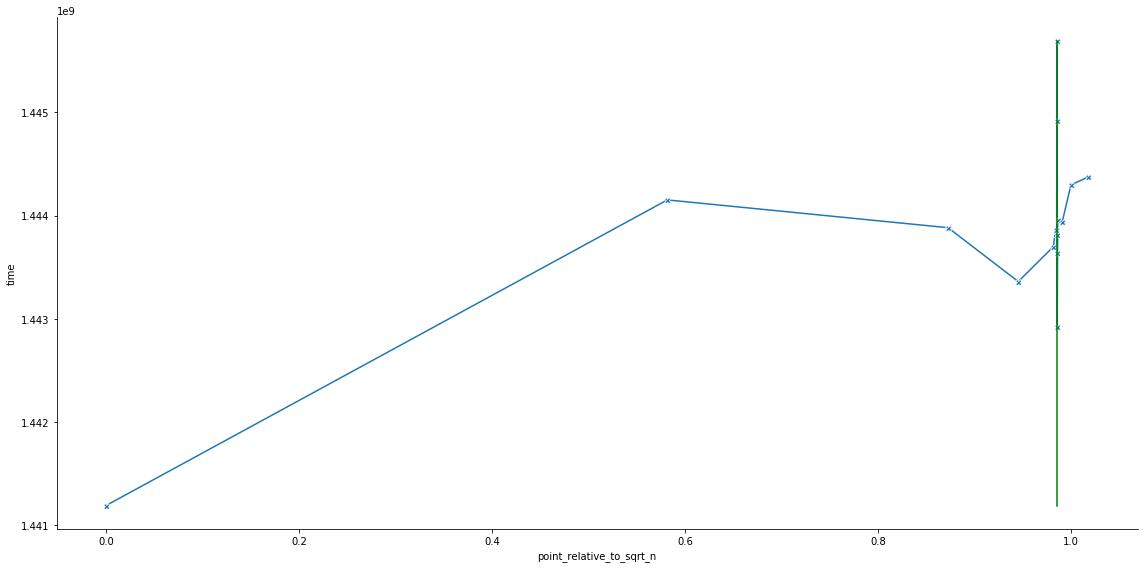

In [33]:
g = seaborn.relplot(
    data=bit_timings, 
    x='point_relative_to_sqrt_n', 
    y='time',
    kind='line', 
    height=8, 
    aspect=16/8, 
    marker="X",
)
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [bit_timings['time'].min(), bit_timings['time'].max()], color='green')
g

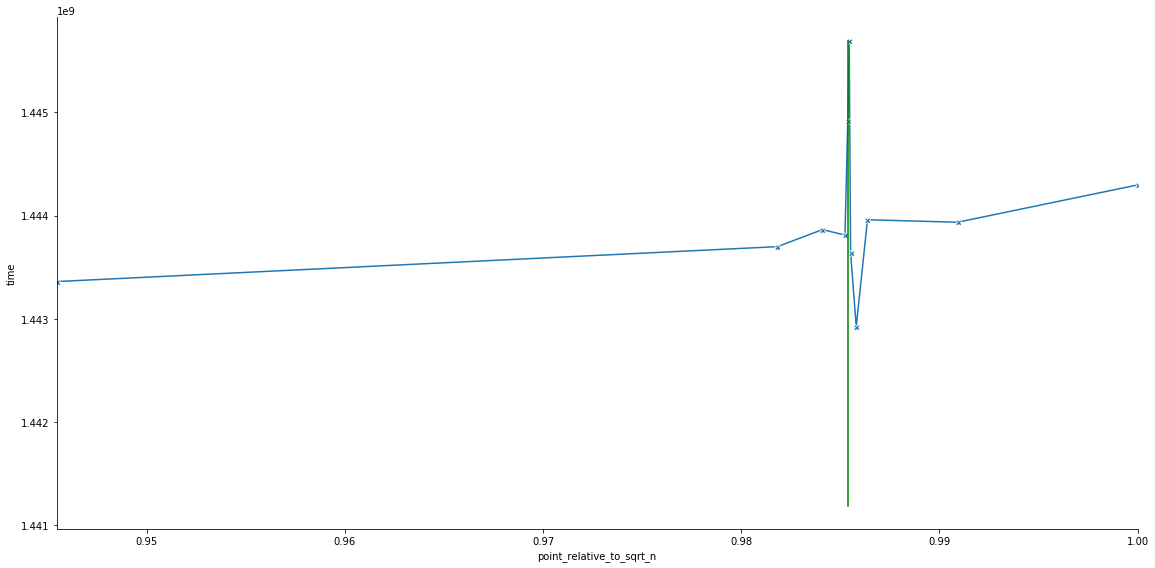

In [34]:
g = seaborn.relplot(
    data=bit_timings, 
    x='point_relative_to_sqrt_n', 
    y='time',
    kind='line', 
    height=8, 
    aspect=16/8, 
    marker="X",
)
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [bit_timings['time'].min(), bit_timings['time'].max()], color='green')
g.set(xlim=(lower_bound_relative_to_sqrt_n, upper_bound_relative_to_sqrt_n))
g

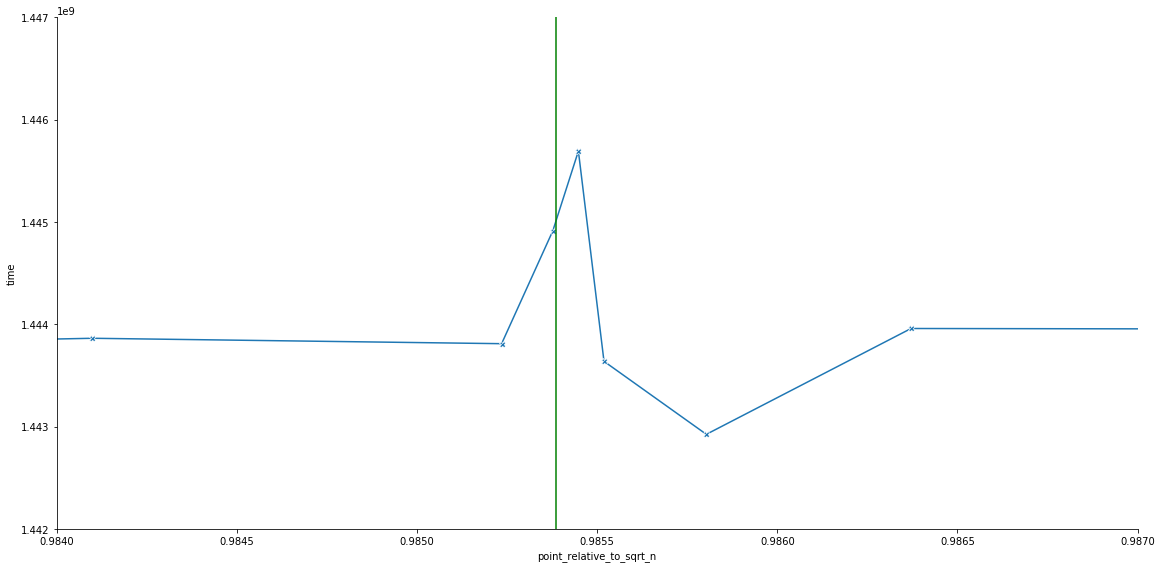

In [35]:
g = seaborn.relplot(
    data=bit_timings, 
    x='point_relative_to_sqrt_n', 
    y='time',
    kind='line', 
    height=8, 
    aspect=16/8, 
    marker="X",
)
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [1.43e9, 1.450e9], color='green')
g.set(ylim=(1.442e9, 1.447e9))
g.set(xlim=(0.984, 0.987))
g

This doesn't look too promising.

## Coppersmiths Attack

## References
  - [1] https://crypto.stanford.edu/~dabo/papers/ssl-timing.pdf